In [ ]:
import re
import nltk

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import random
import itertools

import sys
import os
import argparse
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
import six
from abc import ABCMeta
from scipy import sparse
from scipy.sparse import issparse
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.preprocessing import normalize, binarize, LabelBinarizer
from sklearn.svm import LinearSVC

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
df = pd.read_csv('./Amazon_Unlocked_Mobile.csv')

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

### Data Preprocessing

In [ ]:
df = df.dropna(subset= ['Brand Name', 'Reviews'])
#df.dropna(subset) : 특정 컬럼만 지정하여 결측치 제거 

In [ ]:
df

In [ ]:
df.isnull().sum()
#결측치들이 사라진것을 확인 
#Price, Review Votes의 개수가 줄어든이유
#Brand Name과 Reviews결측치에도 포함되어 있었기때문

In [ ]:
c = df['Price'].fillna(method= 'pad')
# fillna(method = 'pad') :한칸위의 행의 값으로 결측치를 대체 
# 나중에 concat함수로 df에 추가할 예정 

In [ ]:
c.isnull().sum()
#결측치들이 바로 위의 행값으로 대체되었음

In [ ]:
sns.distplot(df['Review Votes'].dropna())

In [ ]:
df['Review Votes'].describe()

In [ ]:
d= df['Review Votes'].fillna(0)

In [ ]:
d.isnull().sum()

In [ ]:
b = pd.concat([c,d], axis = 1)
#Price, Review Votes의 결측치들을 처리한 시리즈들을 합침

In [ ]:
b

In [ ]:
df=df.drop('Price', axis =1 )
df=df.drop('Review Votes', axis =1)
df

In [ ]:
df = pd.concat([df,b], axis = 1)

In [ ]:
df

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
plt.boxplot(df['Rating'], sym="bo")
plt.title('Box plot of Rating')
plt.xticks([1], ['Rating'])
plt.show()

In [ ]:
sns.countplot(df['Rating'])
#5점이 확실히 많은 것을 알 수 있으며 1점 또한 두번째로 많은 것을 볼 수있다 
#즉 점수가 양극화를 보이는 것 같다 

In [ ]:
plt.boxplot(df['Price'], sym="b*")
plt.title('Box plot of Price')
plt.xticks([1], ['Price'])
plt.show()

In [ ]:
sns.distplot(df['Price'])
#대부분의 가격이 700달러 미만이며 2000달러에서 특이한 분포를 보이고 있다.

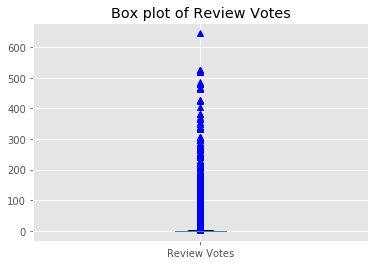

In [26]:
plt.boxplot(df['Review Votes'], sym="b^")
plt.title('Box plot of Review Votes')
plt.xticks([1], ['Review Votes'])
plt.show()

### Correlation

In [28]:
a = df.iloc[:,4:6]
b = df.iloc[:,2]
c = pd.concat([a,b], axis =1)
print(c)
#a : Price와 Review Votes를 슬라이싱한 결과
#b : Rating만을 슬라이싱한 결과
#c : a와 b를 합친 결과 

         Price  Review Votes  Rating
0       199.99           1.0       5
1       199.99           0.0       4
2       199.99           0.0       5
3       199.99           0.0       4
4       199.99           0.0       4
...        ...           ...     ...
413835   79.95           0.0       5
413836   79.95           0.0       3
413837   79.95           0.0       5
413838   79.95           0.0       3
413839   79.95           0.0       4

[348623 rows x 3 columns]


In [29]:
c.corr()
#price와 rating, review_votes간에는 서로 상관관계가 거의 없다고 볼 수 있다.

,Price,Review Votes,Rating
Price,1.000000,0.022088,0.074788
Review Votes,0.022088,1.000000,-0.044608
Rating,0.074788,-0.044608,1.000000


### Rating Mapping

In [30]:
Review_mapping =  {0: '0',1 : '0', 2 :'0',3 : '0', 4 : '1', 5 : '1'}
Review_mapping

{0: '0', 1: '0', 2: '0', 3: '0', 4: '1', 5: '1'}

In [31]:
Rating = lambda x: Review_mapping.get(x,x)
df['Rating']=df.Rating.map(Rating)

In [32]:
df['Rating'].unique()

array(['1', '0'], dtype=object)

### Text Analysis

In [33]:
def review_to_wordlist(review, remove_stopwords = True):

    
    review_text = re.sub('[^a-zA-Z]'," ", review)
    #review_text에 영어만 넣기 
    
    words = review_text.lower().split()
    #소문자로 바꿔주고 그것들을 분리해준다 
    
    if remove_stopwords:
        stops = set(stopwords.words('english'))
        words = [w for w in words if not w in stops]
        #stops에 영어의 불용어를 넣어줌 
        #words는 소문자로 변환되고 띄어져있는 것이며 
        #stops에 있는 불용어를 제외하고 넣어줌 
        
    b = []
    stemmer = english_stemmer
    for word in words:
        b.append(stemmer.stem(word))
        #words에 전처리된것들의 어간들만 추출 
        
    return(b)


In [34]:
train, test = train_test_split(df, test_size = 0.3)

In [35]:
clean_train_reviews = []
for review in train['Reviews']:
    clean_train_reviews.append( " ".join(review_to_wordlist(review)))
    
clean_test_reviews = []
for review in test['Reviews']:
    clean_test_reviews.append( " ".join(review_to_wordlist(review)))
#train과 test의 리뷰들을 토큰화하는 것

In [36]:
clean_train_reviews
#토큰화가 된것을 확인 할 수 있다.

['great custom servic support phone look work great activ new phone eas took minut impress overal purchas',
 'exelent',
 'best purchas sister love',
 'l new phone',
 'unfortun screen shatter mine due incid howev great cute phone great color',
 'love',
 'sorri say check serial number brand new phone found alreadi activ store sold realli decreas valu countri',
 'poor qualiti broke within month would give star could phone poor qualiti case made protect sim card reader stop work month',
 'describ',
 'good',
 'saw black spot dent bottom left new edg unwrap need refund replac',
 'work great got time manner',
 'excel devic',
 'fast deliveri use phone china new phone come san googl app work well vpn first samsung phone came htc happi far pluse replac batteri water resist expand memori',
 'drop phone tile floor last night otterbox save day like color tardi blue ish rubberi feel let put slight slope without phone slide oblivion',
 'research purchas purchas nokia surpris ship fast like track syst

In [67]:
len(clean_train_reviews)

244036

### BOW(Bag Of Word)

##### 벡터화가 잘되었는지를 확인하기위해  5개만 추출

In [68]:
a = clean_train_reviews[0:5]
#5개로 구성된 말뭉치(corpus)를 생성

In [77]:
print(a)

['awesom phone work great', 'thank much pleas deal realli deserv star', 'like new great price want', 'purchas phone suppos new one work fine second one new damag sim card holder miss contact phone unlock contact vendor direct phone line never got back alreadi spent get work current dominican republ brought phone gift relat back us saturday write detail review worst onlin purchas ever made', 'excel product new unlock gsm sim']


In [71]:
vectorizer = CountVectorizer(min_df = 1, ngram_range = (1,1))
#한개의 단어만 추출하도록 하는거

In [74]:
features = vectorizer.fit_transform(a)
print(features)

  (0, 1)	1
  (0, 31)	1
  (0, 51)	1
  (0, 19)	1
  (1, 46)	1
  (1, 26)	1
  (1, 32)	1
  (1, 8)	1
  (1, 36)	1
  (1, 9)	1
  (1, 44)	1
  (2, 19)	1
  (2, 22)	1
  (2, 28)	1
  (2, 33)	1
  (2, 50)	1
  (3, 31)	4
  (3, 51)	2
  (3, 28)	2
  (3, 35)	2
  (3, 45)	1
  (3, 29)	2
  (3, 15)	1
  (3, 41)	1
  (3, 7)	1
  :	:
  (3, 2)	2
  (3, 0)	1
  (3, 43)	1
  (3, 16)	1
  (3, 6)	1
  (3, 12)	1
  (3, 38)	1
  (3, 3)	1
  (3, 17)	1
  (3, 37)	1
  (3, 48)	1
  (3, 40)	1
  (3, 53)	1
  (3, 10)	1
  (3, 39)	1
  (3, 52)	1
  (3, 30)	1
  (3, 13)	1
  (3, 24)	1
  (4, 28)	1
  (4, 42)	1
  (4, 47)	1
  (4, 14)	1
  (4, 34)	1
  (4, 20)	1


In [75]:
print(features.shape)
#5개의 corpus에 54개의 토큰이 생성된것을 확인 

(5, 54)


In [78]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]
#어간들만 추출된것을 확인할 수 있다

54


['alreadi',
 'awesom',
 'back',
 'brought',
 'card',
 'contact',
 'current',
 'damag',
 'deal',
 'deserv']

In [79]:
pd.DataFrame(features.toarray(), columns = vocab).head()
#BOW가 만들어진것을 볼 수 있다
#이런 행렬을 희소행렬(대부분이 0으로 구성된 행렬)이라고 한다.

,alreadi,awesom,back,brought,card,contact,current,damag,deal,deserv,...,star,suppos,thank,unlock,us,vendor,want,work,worst,write
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,2,1,1,2,1,1,0,0,...,0,1,0,1,1,1,0,2,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


##### 전체 데이터셋을 BOW로 변환

In [81]:
train_features = vectorizer.fit_transform(clean_train_reviews)
test_features = vectorizer.fit_transform(clean_test_reviews)

In [82]:
train_features

<244036x37120 sparse matrix of type '<class 'numpy.int64'>'
	with 4087842 stored elements in Compressed Sparse Row format>

### TF-IDF

In [193]:
tfidf = TfidfVectorizer().fit(a)
tfidf.transform(a).toarray()

array([[0.        , 0.5819515 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.4695148 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4695148 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.4695148 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.37796447, 0.37796447,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0. 

In [194]:
print(tfidf.vocabulary_)

{'awesom': 1, 'phone': 31, 'work': 51, 'great': 19, 'thank': 46, 'much': 26, 'pleas': 32, 'deal': 8, 'realli': 36, 'deserv': 9, 'star': 44, 'like': 22, 'new': 28, 'price': 33, 'want': 50, 'purchas': 35, 'suppos': 45, 'one': 29, 'fine': 15, 'second': 41, 'damag': 7, 'sim': 42, 'card': 4, 'holder': 21, 'miss': 25, 'contact': 5, 'unlock': 47, 'vendor': 49, 'direct': 11, 'line': 23, 'never': 27, 'got': 18, 'back': 2, 'alreadi': 0, 'spent': 43, 'get': 16, 'current': 6, 'dominican': 12, 'republ': 38, 'brought': 3, 'gift': 17, 'relat': 37, 'us': 48, 'saturday': 40, 'write': 53, 'detail': 10, 'review': 39, 'worst': 52, 'onlin': 30, 'ever': 13, 'made': 24, 'excel': 14, 'product': 34, 'gsm': 20}


In [195]:
train_tfidf = TfidfVectorizer().fit(clean_train_reviews)
test_tfidf = TfidfVectorizer().fit(clean_test_reviews)

워드 임베딩 
 - 단어를 벡터로 표현하는것 
 - 희소행렬 : 대부분이 0으로 구성되어 있는 행렬
 - 밀집행렬 : 희소행렬과 반대라고 생각하면 된다 
 - 단어를 밀집 벡터의 형태로 표현하는 방법을 워드 임베딩이라고 한다
 - 이 밀집 벡터를 워드 임베딩 광정을 통해 나온 결과가 임베딩 벡터이다 
 - 방법로으로는 LSA, Word2Vec, FastText, Glove등이 존재한다 
 - One - Hot Vector는 단어간 유사도를 계산할 수 없다는 단점이 존재한다
 - 단어간 유사도를 반영할 수 있도록 단어의 의미를 벡터화하는 것의 대표적인 방법이 Word2Vec이다.

 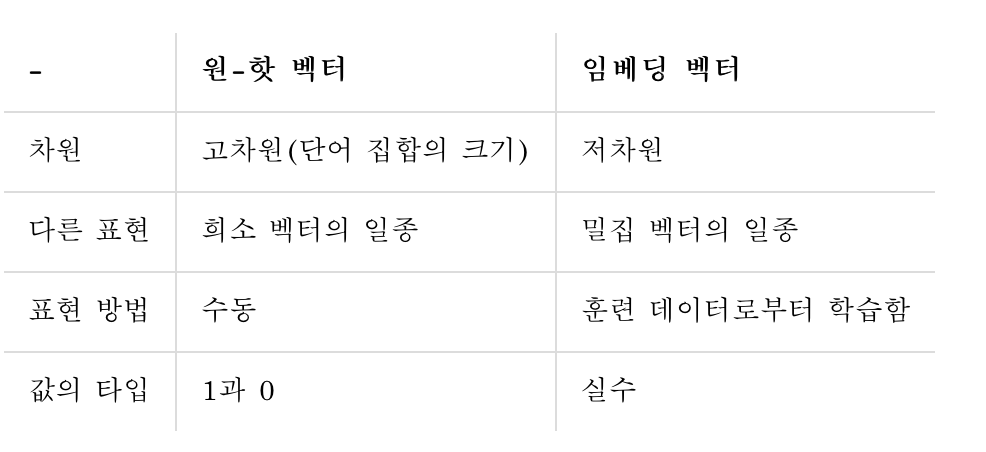

Word2Vec

 - CBOW(Continuous Bag of Words)와 Skip-Gram이 존재 
 - CBOW : 주변에 있는 단어들로 중간 단어들을 예측
 - Skip-Gram : 중간에 있는 단어로 주변 단어를 예측 

In [167]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

In [176]:
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize = (8,6))
    plt.scatter(xs, ys, marker = 'o')
    for i,v in enumerate(vocabs):
        plt.annotate(v, xy= (xs[i], ys[i]))

In [181]:
sentences = [
            ['this','is', 'a', 'good', ' product'],
            ['it', ' is', 'a', 'excellent', 'product'],
            ['it', 'is', 'a', 'bad', 'product'],
            ['that', 'is', 'the', 'worst', 'product']
]

In [182]:
model = Word2Vec(sentences, size = 300, window =3, min_count = 1, workers =1)

In [192]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()
word_vectors_list = [word_vectors[v] for v in vocabs]
print(word_vectors.similarity(w1 = 'excellent', w2 = 'worst'))

-0.059028685


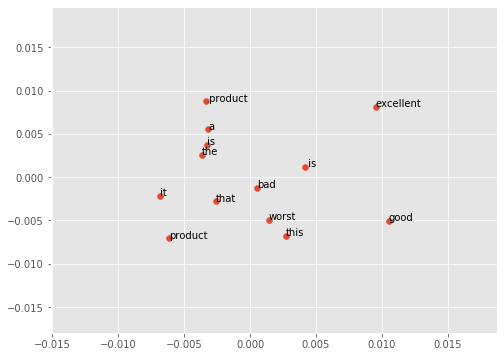

In [190]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]
plot_2d_graph(vocabs, xs, ys)

# ================ 5/1

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np

In [198]:
clean_train_reviews 

['awesom phone work great',
 'thank much pleas deal realli deserv star',
 'like new great price want',
 'purchas phone suppos new one work fine second one new damag sim card holder miss contact phone unlock contact vendor direct phone line never got back alreadi spent get work current dominican republ brought phone gift relat back us saturday write detail review worst onlin purchas ever made',
 'excel product new unlock gsm sim',
 'hour set horribl',
 'start rate give consid cheap buck amaz phone disappoint compar devic like iphon galaxi floor capabl qualiti price point honest low price expect would piec junk would send back mass posit review convinc give tri month hook blu never get phone contract overpay phone pro valu money camera qualiti android minim bloatwar includ silicon case screen cover screen qualitycon littl slow',
 'great',
 'phone goe dead turn back organ screen mess move app back spot also ran room ad memori card husband abl add pictur memori card back everyth factori re

In [45]:
train_X = clean_train_reviews
test_X = clean_test_reviews
train_y = train['Rating']
test_y = test['Rating']


In [46]:
learner = Pipeline([
    ('vect', CountVectorizer()), #max_features= 숫자 숫자만큼 자르겠다 , min_df =5 하위 5개 이하단어는 자르겠다 등등 많다 
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=100)) # 이파라미터들을 조정하면서 결과출력
])

learner2 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='linear')) 
    #svm장점은 데이터에 노이즈가 많거나 데이터의 분포가 선형으로 분류가 불가능하더라도
    #커널을 사용하면 선형으로 분류할 수 있는 공간으로 가능하기 때문 
    #단점은 텍스트데이터에서는 어떤 커널을 사용해야하는지 알 수 없다 
    #그래서 커널들을 각각 다 넣어줘야한다 
])

learner3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='poly', degree=8))#clf은 classfier
    #poly는 degree(차원)를 줘야한다 
])

learner4 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='rbf'))
])

learner5 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(kernel='sigmoid'))
])

learner6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mb', MultinomialNB()) #나이브베이즈모델도 생각보다 성능이 좋다 
])

#학습기 정하기 
#이렇게 파이프라인을 쓰면 숫자만 변경해주면 되므로 굉장히 좋다 
#learner2,3,4,5는 시간이 너무 많이 걸려서 못함
classifier = learner

#실제 학습 
classifier.fit(train_X, train_y)
train_predict = classifier.predict(train_X)
train_accuracy = np.mean(train_predict == train_y)
#accuracy는 예측값과 실제값을 평균을 낸게 실제 예측값이다 

test_predict = classifier.predict(test_X)
test_accuracy = np.mean(test_predict == test_y)


print("For %d test data" % len(test_X))

print("Training Accuracy : %.2f" % train_accuracy)
print("Test Accuracy : %.2f" % test_accuracy)

For 104587 test data
Training Accuracy : 0.88
Test Accuracy : 0.87


In [48]:
from sklearn.linear_model import LogisticRegression

NameError: name 'features' is not defined